In [1]:
import torch
import torch.nn as nn
import FrEIA.framework as Ff
import FrEIA.modules as Fm
import pandas as pd
import torch.distributions as dist
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import matplotlib

from os.path import exists
from helpers import *
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from argparse import ArgumentParser

matplotlib.rcParams['figure.figsize'] = [15, 10]
plt.rcParams.update({'axes.labelsize': 14})

In [56]:
parser = ArgumentParser()
parser.add_argument("-c", "--cuda", dest="cuda", default=0, type=int, help='Cuda number')
parser.add_argument("--batch", dest="batch", default=5000, type=int, help='batch size')
parser.add_argument("--lr", dest="lr", default=0.001, type=float, help='learning rate')
parser.add_argument("--test", dest="test", default=0, type=int, help='Test run {True, False}')

_StoreAction(option_strings=['--test'], dest='test', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help='Test run {True, False}', metavar=None)

In [57]:
parser.add_argument("-f", '--flows', dest="flows", default=2, type=int, help='Number of flows')
parser.add_argument("--nn-hidden", dest="nn_hidden", default=2, type=int, help='Number of hidden layers for the NN')
parser.add_argument("--nn-nodes", dest="nn_nodes", default=150, type=int, help='Number of hidden nodes for NN')

_StoreAction(option_strings=['--nn-nodes'], dest='nn_nodes', nargs=None, const=None, default=150, type=<class 'int'>, choices=None, help='Number of hidden nodes for NN', metavar=None)

In [58]:
args = parser.parse_args()

In [59]:
print(args)
folder = 'output/'
ensure_dir(folder)
device = torch.device('cuda:'+str(args.cuda))
device = torch.device('cpu')

In [44]:
if exists('/ceph/lsowa/recoil/dt.root'):
    dfdata = load_from_root('/ceph/lsowa/recoil/dt.root', test=args.test)
    dfmc = load_from_root('/ceph/lsowa/recoil/mc.root', test=args.test)
else:
    # when running on cluster
    dfdata = load_from_root('recoil/dt.root', test=args.test)
    dfmc = load_from_root('recoil/mc.root', test=args.test)

Reading:  /ceph/lsowa/recoil/dt.root
Reading:  /ceph/lsowa/recoil/mc.root


In [101]:
print('MC shape ', dfmc.shape)
print('Data shape ', dfdata.shape)

MC shape  (2189044, 213)
Data shape  (1796149, 172)


In [102]:
cond = ['pt_vis_c', 'phi_vis_c', 'dxyErr_1', 'dxyErr_2', 'dxy_1', 'dxy_2',  'dxybs_1',
        'dxybs_2', 'dzErr_1', 'dzErr_2', 'dz_1', 'dz_2', 'eta_1', 'eta_2', 'highPtId_1',
        'highPtId_2', 'highPurity_1', 'highPurity_2', 'mass_1', 'mass_2', 'metSumEt', 'metcov00',
        'metcov01', 'metcov10', 'metcov11', 'metphi', 'mjj', 'phi_1', 'phi_2', 'ptErr_1', 
        'ptErr_2', 'pt_1', 'pt_2']
cond = ['metphi','pt_vis_c', 'phi_vis_c','pt_1', 'pt_2','dxy_1', 'dxy_2','dz_1',
        'dz_2','eta_1', 'eta_2','mass_1', 'mass_2','metSumEt']
#cond = ['pt_vis_c', 'phi_vis_c','pt_1', 'pt_2','dxy_1', 'dxy_2','dz_1',
#        'dz_2','eta_1', 'eta_2','mass_1', 'mass_2']
names = ['uP1_uncorrected', 'uP2_uncorrected']

In [108]:
data = dfdata[names].to_numpy().astype(float)
mc = dfmc[names].to_numpy().astype(float)
cdata = dfdata[cond].to_numpy().astype(float)
cmc = dfmc[cond].to_numpy().astype(float)

In [109]:
ptz = dfmc['pt_vis_c']

In [110]:
if False:#args.test:
    n = 2000
    data = data[:n,:]
    cdata = cdata[:n,:]
    #mc = mc[:n,:]
    #cmc = cmc[:n,:]
    #ptz = ptz[:n] # MC

In [111]:
# Z standardize inputs

In [112]:
input_scaler = StandardScaler()
data = input_scaler.fit_transform(data)
mc = input_scaler.transform(mc)

cond_scaler = StandardScaler()
cdata = cond_scaler.fit_transform(cdata)
cmc = cond_scaler.transform(cmc)

In [115]:
data, data_val, cdata, cdata_val = train_test_split(data, cdata, test_size=0.2)

In [116]:
data, mc, cdata, cmc = torch.tensor(data), torch.tensor(mc), torch.tensor(cdata), torch.tensor(cmc)
data_val, cdata_val = torch.tensor(data_val).to(device), torch.tensor(cdata_val).to(device)

In [ ]:
print('Train (Data): ', data.shape, ' Conditions: ', cdata.shape)
print('Val (Data): ', data_val.shape, ' Conditions: ', cdata_val.shape)
print('Test (MC): ', mc.shape, ' Conditions: ', cmc.shape)

Setup Model

In [117]:
def mlp_constructor(input_dim=2, out_dim=2, hidden_nodes=args.nn_nodes):
    
    layers = [nn.Linear(input_dim, hidden_nodes), nn.ReLU()]
    for n in range(args.nn_hidden-1):
        layers.append(nn.Linear(hidden_nodes, hidden_nodes))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_nodes, out_dim))
    
    model = nn.Sequential(*layers)
    return model

In [118]:
model = Ff.SequenceINN(2)
for k in range(args.flows):
    model.append(Fm.RNVPCouplingBlock, subnet_constructor=mlp_constructor, 
                    clamp=2, cond=0, cond_shape=(cmc.shape[1],))


Training


In [119]:
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, 
                                                    patience=3, verbose=True)

In [120]:
cdata.shape

torch.Size([1436919, 14])

In [121]:
dataset = TensorDataset(data, cdata)
loader = DataLoader(dataset, shuffle=True, batch_size=args.batch, num_workers=4)

In [125]:
pz = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
model.to(device)

def nll(z, log_jac):
    zz = torch.sum(z**2, dim=-1)
    neg_log_likeli = 0.5 * zz - log_jac
    loss = torch.mean(neg_log_likeli)
    return loss

losses = []
losses_val = []
nbatches = len(loader)
stopper=0
best_loss=np.inf
epoch = 0
best_model_dict = None
while stopper<=15:
    epo_loss = 0
    for d, c in loader:
        d = d.to(device)
        c = c.to(device)
        
        z, log_jac = model(d.float(), c=[c.float()])
        loss = nll(z, log_jac)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epo_loss += loss.cpu().detach().numpy()
    epo_loss /= nbatches
    epo_loss = round(epo_loss,5)
    scheduler.step(epo_loss)
    losses.append(epo_loss)
    
    # validation
    z, log_jac = model(data_val.float(), c=[cdata_val.float()])
    loss_val = nll(z, log_jac)
    loss_val = loss_val.cpu().detach().numpy()
    losses_val.append(loss_val)
    if loss_val >= best_loss: 
        stopper+=1
    else:
        best_loss = loss_val
        stopper = 0
        best_model_dict = model.state_dict()
    epoch += 1
    print('Epoch: {:.0f}; train Loss: {:.3f}; val Loss: {:.3f}; stopper: {:.0f}; best val loss: {:.3f}\n'.format(epoch, epo_loss, loss_val, stopper, best_loss))
    
    if epoch >= args.test and args.test > 0:
        break

Epoch: 1; train Loss: -3.592; val Loss: -3.76; stopper: 0; best loss: -3.762

Epoch: 2; train Loss: -3.697; val Loss: -3.84; stopper: 0; best loss: -3.844

Epoch: 3; train Loss: -3.793; val Loss: -3.73; stopper: 1; best loss: -3.844

Epoch: 4; train Loss: -3.861; val Loss: -3.91; stopper: 0; best loss: -3.912

Epoch: 5; train Loss: -3.889; val Loss: -4.08; stopper: 0; best loss: -4.080

Epoch: 6; train Loss: -3.925; val Loss: -3.8; stopper: 1; best loss: -4.080



KeyboardInterrupt: 

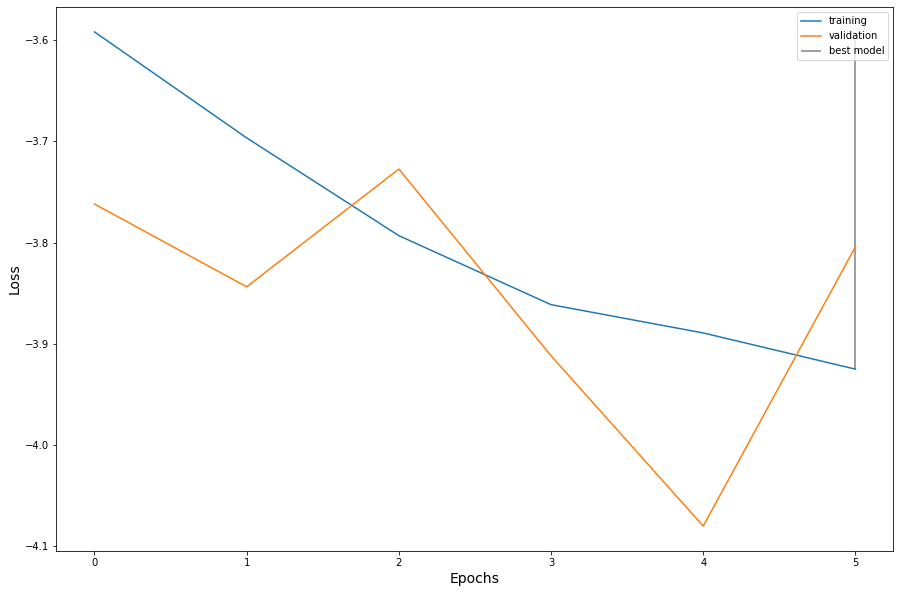

In [126]:
plt.plot(losses, label='training')
plt.plot(losses_val, label='validation')
plt.vlines(len(losses)-stopper, ymin=np.min(losses), ymax=np.max(losses), 
            label='best model', colors=['grey'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(folder+'loss.pdf')

In [ ]:
model.load_state_dict(best_model_dict)
torch.save(model.state_dict(), folder+'model.pt')
os.system('cp ' + os.path.basename(__file__) + ' ' + folder + 'code.py') 

Text(0, 0.5, 'Loss')

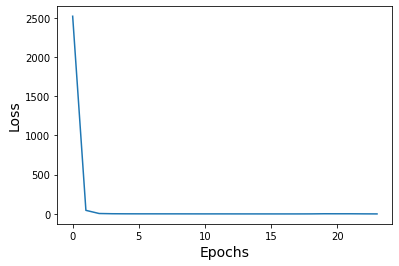

In [116]:
print('Training done')


Evaluation


In [117]:
# Predict gaussian z
model.cpu()
z = evaluate_sequential(model, data.float(), cond=cdata.float())
#z, _ = model(data.float(), c=[cdata.float()])
gaussian = pz.sample((100000, ))

<All keys matched successfully>


    Gaussian Density Plot


In [118]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), gridspec_kw={'width_ratios': [2, 1],
                                                            'height_ratios': [1, 2]})
plt.subplots_adjust(hspace=0, wspace=0)
xlim = [-3, 3]
ylim = [-3, 3]

# heatmap
ax[1,0].hexbin(x=z[:,0].cpu().detach().numpy(), y=z[:,1].cpu().detach().numpy(), 
                label='model(data)', gridsize=(50,50), cmap='Blues', edgecolors=None)
#counts, ybins, xbins, image = ax[1,0].hist2d(gaussian[:,0].cpu().detach().numpy(), 
#                                                gaussian[:,1].cpu().detach().numpy(), 
#                                                bins=20, alpha=0.0)
counts, ybins, xbins = np.histogram2d(gaussian[:,0].cpu().detach().numpy(), 
                                                gaussian[:,1].cpu().detach().numpy(), 
                                                bins=20)
contours = ax[1,0].contour(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                colors='orange', levels=3)
ax[1,0].plot([], [], '-', label='gaussian', color='orange')
ax[1,0].set_ylim([-3, 3])
ax[1,0].set_xlim(xlim)
ax[1,0].set_xlabel('x')
ax[1,0].set_ylabel('y')
ax[1,0].legend(loc='lower left', bbox_to_anchor=(1,1))

# x axis
_ = ax[0,0].hist(z[:,0].cpu().detach().numpy(), bins=100, density=True, label='model(data)')
_ = ax[0,0].hist(gaussian[:,0].cpu().detach().numpy(), bins=100, 
                    density=True, histtype=u'step', label='gaussian')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_ylabel('a.u.')
ax[0,0].set_xlim(xlim)

# y axis
_ = ax[1,1].hist(z[:,1].cpu().detach().numpy(), bins=100, density=True, 
                    label='model(data)',orientation='horizontal')
_ = ax[1,1].hist(gaussian[:,1].cpu().detach().numpy(), bins=100, density=True, 
                    histtype=u'step', label='gaussian', orientation='horizontal')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set_xlabel('a.u.')
ax[1,1].set_ylim(xlim)

# third wheel
_ = ax[0,1].axis('off')

plt.savefig(folder+'gaussian_density.pdf')
plt.clf()

Predict y

In [89]:
z = pz.sample((cmc.shape[0], ))
u = evaluate_sequential(model, z, cmc.float(), rev=True)
#u, log_jac = model(z, rev=True, c=[cmc.float()])
u = u.cpu().detach().numpy()
u = input_scaler.inverse_transform(u)
data = input_scaler.inverse_transform(data)

### Compare MC -> Data

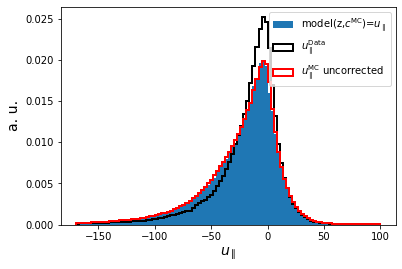

In [91]:
# u parallel
interval = [-170, 100]
_ = plt.hist(u[:,0], density=True, bins=100, range=interval, label=r'model(z,$c^\mathrm{MC}$)=$u_\parallel$')
_ = plt.hist(data[:,0], histtype=u'step', density=True, bins=100, 
                range=interval, linewidth=2, color='black', label=r'$u^\mathrm{Data}_\parallel$')
_ = plt.hist(dfmc['uP1_uncorrected'].values, histtype=u'step', density=True, 
                bins=100, range=interval, linewidth=2, color='red', label=r'$u^\mathrm{MC}_\parallel$ uncorrected')
plt.xlabel(r'$u_\parallel$')
plt.ylabel('a. u.')
plt.legend()
plt.savefig(folder+'u_parallel.pdf')
plt.clf()

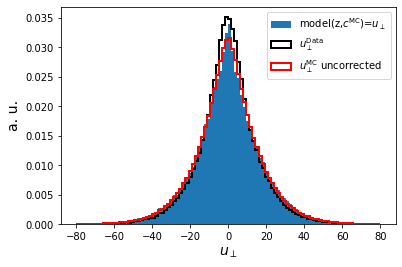

In [92]:
# u perp
interval = [-80, 80]
_ = plt.hist(u[:,1], density=True, bins=100, range=interval, label=r'model(z,$c^\mathrm{MC}$)=$u_\perp $')
_ = plt.hist(data[:,1], histtype=u'step', density=True, bins=100, range=interval, 
                linewidth=2, color='black', label=r'$u^\mathrm{Data}_\perp $')
_ = plt.hist(dfmc['uP2_uncorrected'].values, histtype=u'step', density=True, bins=100, 
                range=interval, linewidth=2, color='red', label=r'$u^\mathrm{MC}_\perp $ uncorrected')
plt.xlabel(r'$u_\perp$')
plt.ylabel('a. u.')
plt.legend()
plt.savefig(folder+'u_perp.pdf')
plt.clf()

response

In [93]:
up = u[:,0]

In [94]:
xmin = 25
xmax = 200

In [95]:
keep = np.logical_and(xmax > ptz, ptz > xmin)
ptz = ptz[keep]
up = up[keep]
r = -up/ptz

In [ ]:
bins = np.linspace(xmin,xmax,10)
bin_mids = (bins[1:]-bins[:-1])/2 + bins[:-1]
hist_raw, edges = np.histogram(ptz, bins = bins, range=[xmin, xmax])
hist_weighted, edges = np.histogram(ptz, bins = bins, weights=r, range=[xmin, xmax])

(20.0, 200.0)

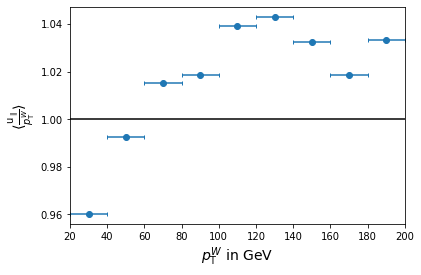

In [96]:
#plt.plot(bin_mids, hist_weighted/hist_raw, '.')
plt.hlines([1], bins.min(), bins.max(), color='black')
plt.errorbar(x=bin_mids, y=hist_weighted/hist_raw,
            xerr=(bins[1:]-bins[:-1])/2, fmt='o', capsize=2)
plt.xlabel(r'$p_\mathrm{T}^W$ in GeV')
plt.ylabel(r'$\langle \frac{\mathrm{u}_\parallel}{p_\mathrm{T}^W}\rangle$')
plt.xlim([bins.min(), bins.max()])
plt.savefig(folder+'response.pdf')
plt.clf()

Text(0, 0.5, 'a.u.')

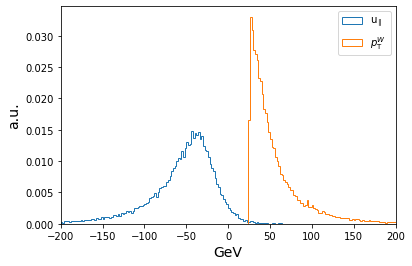

In [97]:
n, bins, edges = plt.hist(up, histtype=r'step', bins=200, range=[-200, 200], 
                            density=True, label=r'$\mathrm{u}_\parallel$')
n1, bins1, edges1 = plt.hist(ptz, histtype=r'step', bins=200, range=[-200, 200], 
                                density=True, label=r'$p_\mathrm{T}^W}\rangle$')
plt.xlim([-200, 200])
plt.legend()
plt.xlabel('GeV')
plt.ylabel('a.u.')
plt.savefig(folder+'uperp_ptw.pdf')
plt.clf()